In [2]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np

In [1]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [29]:
pd.set_option('display.max_colwidth', None)

In [7]:
# read calfire_2001_2023.shp
gdf = gpd.read_file('../Fire_Data/calfire_2001_2023.shp')

# remove rows that have ALARM_DATE and CONT_DATE as NaT, print the number of rows removed
gdf = gdf[~(gdf['ALARM_DATE'].isna() & gdf['CONT_DATE'].isna())]

In [8]:
# Check the current CRS of the GeoDataFrame
print(gdf.crs)

# If the CRS is not set or incorrect, set it (replace 'EPSG:3310' with the correct EPSG code)
if gdf.crs is None or gdf.crs.to_string() != 'EPSG:3310':
    gdf = gdf.set_crs('EPSG:3310')

# Transform the GeoDataFrame to WGS84 (EPSG:4326)
gdf_wgs84 = gdf.to_crs('EPSG:4326')

EPSG:3310


In [9]:
# check if any rows has ALARM_DATE start with 0, if so, print the data, only ALARM_DATE, CONT_DATE
gdf_wgs84[gdf_wgs84['ALARM_DATE'].astype(str).str.startswith('0')][['YEAR_','ALARM_DATE', 'CONT_DATE']]

,YEAR_,ALARM_DATE,CONT_DATE
1662,2019,0219-05-29,0219-05-29


In [10]:
# Function to correct the date
def correct_date(row):
    year = str(row['YEAR_'])
    if row['ALARM_DATE'] and row['ALARM_DATE'].startswith('0'):
        row['ALARM_DATE'] = year + row['ALARM_DATE'][4:]
    if row['CONT_DATE'] and row['CONT_DATE'].startswith('0'):
        row['CONT_DATE'] = year + row['CONT_DATE'][4:]
    return row

# Apply the function to correct the dates
gdf_wgs84 = gdf_wgs84.apply(correct_date, axis=1)

In [11]:
gdf_wgs84.iloc[1662][['YEAR_','STATE','ALARM_DATE', 'CONT_DATE']]

YEAR_               2019
STATE                 CA
ALARM_DATE    2019-10-24
CONT_DATE     2019-10-24
Name: 1666, dtype: object

In [12]:
gdf_wgs84.shape

(7607, 20)

In [13]:
# filter out northern california
gdf_wgs84 = gdf_wgs84[gdf_wgs84.geometry.centroid.y < 42]
# gdf_wgs84 = gdf_wgs84[gdf_wgs84['GIS_ACRES'] > 100]
gdf_wgs84.shape

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_3520\1933565770.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_wgs84 = gdf_wgs84[gdf_wgs84.geometry.centroid.y < 42]


(7597, 20)

In [14]:
# extract the centroid of gdf_wgs84 to a new column
gdf_wgs84['centroid'] = gdf_wgs84.centroid

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_3520\1857600888.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_wgs84['centroid'] = gdf_wgs84.centroid


In [16]:
files = os.listdir('../Weather_Data/')
files

['dead_fuel_moisture_1000hr.2001.2023.CA.nc',
 'dead_fuel_moisture_100hr.2001.2023.CA.nc',
 'max_air_temperature.2001.2023.CA-008.nc',
 'max_relative_humidity.2001.2023.CA.nc',
 'min_air_temperature.2001.2023.CA-009.nc',
 'min_relative_humidity.2001.2023.CA.nc',
 'Palmer_Drought_Severity_Index.2001.2023.CA.nc',
 'precipitation_amount.2001.2023.CA.nc',
 'specific_humidity.2001.2023.CA.nc',
 'surface_downwelling_shortwave_flux.2001.2023.CA.nc',
 'wind_from_direction.2001.2023.CA.nc',
 'wind_speed.2001.2023.CA.nc']

In [17]:
data_dir = '../Weather_Data/'
# Load the first dataset to use as a reference
reference_ds = xr.open_dataset(os.path.join(data_dir, files[0]))

In [21]:
# go through all the files in ../Weather_Data/, print the dimensions and coordinates
for file in files:
    ds = xr.open_dataset(os.path.join(data_dir, file))
    print(f"File: {file}")
    print(f"Dimensions: {ds.dims}")
    print(f"Coordinates: {ds.coords}")
    print(f"Data variables: {ds.data_vars}")
    print()

File: dead_fuel_moisture_1000hr.2001.2023.CA.nc
Dimensions: Frozen({'day': 8400, 'lon': 259, 'lat': 240})
Coordinates: Coordinates:
  * day      (day) datetime64[ns] 2001-01-01 2001-01-02 ... 2023-12-31
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -114.1 -114.1 -114.0
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.15 32.11 32.07 32.03
Data variables: Data variables:
    dead_fuel_moisture_1000hr  (day, lat, lon) float32 ...

File: dead_fuel_moisture_100hr.2001.2023.CA.nc
Dimensions: Frozen({'day': 8400, 'lon': 259, 'lat': 240})
Coordinates: Coordinates:
  * day      (day) datetime64[ns] 2001-01-01 2001-01-02 ... 2023-12-31
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -114.1 -114.1 -114.0
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.15 32.11 32.07 32.03
Data variables: Data variables:
    dead_fuel_moisture_100hr  (day, lat, lon) float32 ...

File: max_air_temperature.2001.2023.CA-008.nc
Dimensions: Frozen({'day': 8400, 'lon': 259, 'lat'

In [18]:
# Function to check if dimensions and coordinates match
def check_compatibility(ds1, ds2):
    return ds1.dims == ds2.dims and all(ds1.coords[dim].equals(ds2.coords[dim]) for dim in ds1.dims)

# Initialize a list to store datasets
datasets = [reference_ds]

# Iterate over the remaining files and check compatibility
for file in files[1:]:
    file_name = file.split('.')[0]
    ds = xr.open_dataset(os.path.join(data_dir, file))
    # if file_name contains temperature, rename the variable to file_names
    if 'temperature' in file or 'relative_humidity' in file:
        # get the name of data variable
        current_data_var_name = list(ds.data_vars)[0]
        # rename the data variable
        ds = ds.rename({current_data_var_name: file_name})
        # print the replacement action
        print(f"Renaming {current_data_var_name} to {file_name}")
    if check_compatibility(reference_ds, ds):
        datasets.append(ds)
    else:
        print(f"Dimensions or coordinates do not match for file: {file}")

Renaming air_temperature to max_air_temperature
Renaming relative_humidity to max_relative_humidity
Renaming air_temperature to min_air_temperature
Renaming relative_humidity to min_relative_humidity
Dimensions or coordinates do not match for file: Palmer_Drought_Severity_Index.2001.2023.CA.nc


In [163]:
# check vegetation_dat from Vegetation_Data/
vegetation_dat = xr.open_dataset('../Vegetation_Data/vegetation.nc')

In [164]:
vegetation_dat

<xarray.Dataset>
Dimensions:  (lon: 205, lat: 230)
Coordinates:
  * lon      (lon) float64 -124.4 -124.4 -124.3 -124.3 ... -116.0 -116.0 -115.9
  * lat      (lat) float64 42.08 42.04 41.99 41.95 ... 32.66 32.62 32.58 32.54
Data variables:
    type     (lat, lon) float32 ...
Attributes:
    Conventions:      CF-1.0
    Source_Software:  Esri ArcGIS

In [165]:
# transform vegetation_dat from xarray to panda
vegetation_dat = vegetation_dat.to_dataframe().reset_index()

In [169]:
# check % of NA in column type
vegetation_dat['type'].isna().sum() / vegetation_dat.shape[0]

0.6243054082714741

In [170]:
# drop rows with NA in column type
vegetation_dat = vegetation_dat.dropna(subset=['type'])

In [171]:
vegetation_dat.shape

(17714, 3)

In [172]:
vegetation_dat.head()

,lon,lat,type
269,-124.374975,40.452058,7.0
270,-124.374975,40.410392,25.0
496,-124.333309,40.577058,1.0
497,-124.333309,40.535392,8.0
498,-124.333309,40.493725,25.0


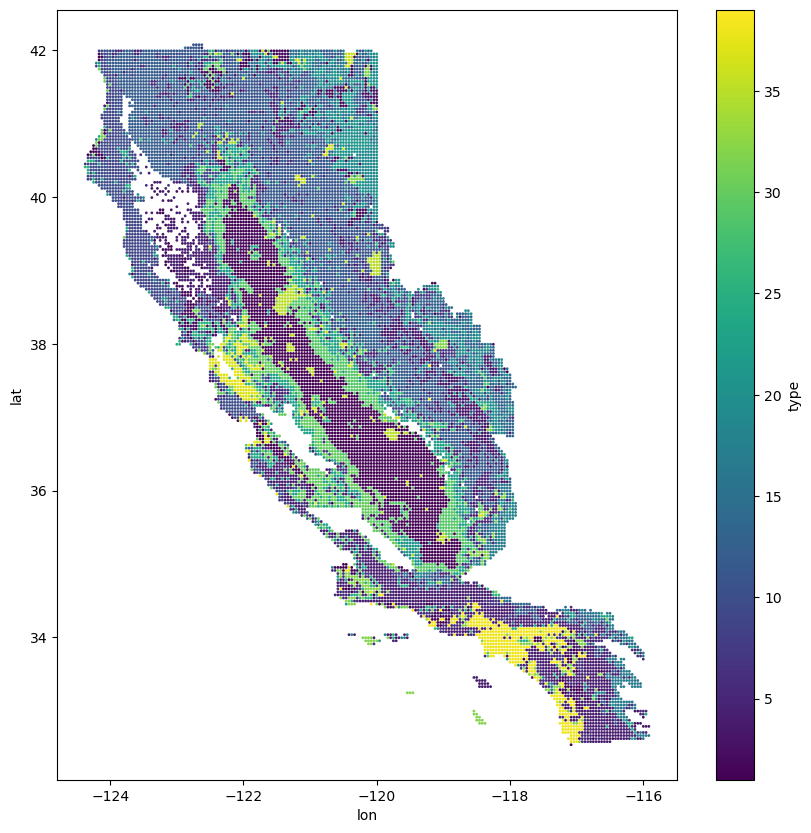

In [174]:
# plot the vegetation_dat
vegetation_dat.plot(kind='scatter', x='lon', y='lat', c='type', cmap='viridis', s=1, figsize=(10, 10))
plt.show()

In [19]:
# merge all datasets
merged_weather_dat = xr.merge(datasets)

In [20]:
# Print the dataset summary
print(merged_weather_dat)

# Print the coordinates
# print(merged_weather_dat.coords)

# Print the data variables
# print(merged_weather_dat.data_vars)

<xarray.Dataset>
Dimensions:                                    (day: 8400, lon: 259, lat: 240)
Coordinates:
  * day                                        (day) datetime64[ns] 2001-01-0...
  * lon                                        (lon) float64 -124.8 ... -114.0
  * lat                                        (lat) float64 41.98 ... 32.03
Data variables:
    dead_fuel_moisture_1000hr                  (day, lat, lon) float32 ...
    dead_fuel_moisture_100hr                   (day, lat, lon) float32 ...
    max_air_temperature                        (day, lat, lon) float64 ...
    max_relative_humidity                      (day, lat, lon) float32 ...
    min_air_temperature                        (day, lat, lon) float64 ...
    min_relative_humidity                      (day, lat, lon) float32 ...
    precipitation_amount                       (day, lat, lon) float32 ...
    specific_humidity                          (day, lat, lon) float32 ...
    surface_downwelling_shortwave_flux

In [21]:
#import numpy as np
#from tqdm import tqdm

# Function to find the nearest longitude and latitude
def find_nearest(lon, lat, lon_array, lat_array):
    lon_grid, lat_grid = np.meshgrid(lon_array, lat_array)
    dist = np.sqrt((lon_grid - lon)**2 + (lat_grid - lat)**2)
    idx = np.argmin(dist)
    return np.unravel_index(idx, lon_grid.shape)

# Initialize lists to store the nearest indices
nearest_lons = []
nearest_lats = []

# Iterate over the centroids
for centroid in tqdm(gdf_wgs84['centroid']):
    lon = centroid.x
    lat = centroid.y
    lat_idx, lon_idx = find_nearest(lon, lat, merged_weather_dat.lon.values, merged_weather_dat.lat.values)
    nearest_lon = merged_weather_dat.lon.values[lon_idx]
    nearest_lat = merged_weather_dat.lat.values[lat_idx]
    nearest_lons.append(nearest_lon)
    nearest_lats.append(nearest_lat)

# Add the nearest indices to the GeoDataFrame
gdf_wgs84['nearest_lon'] = nearest_lons
gdf_wgs84['nearest_lat'] = nearest_lats

  0%|          | 0/7597 [00:00<?, ?it/s]

100%|██████████| 7597/7597 [00:04<00:00, 1591.79it/s]


In [100]:
# read the parquet file
panda_df = pd.read_parquet('../Clean_Data/merged_weather_data_limited_locations.parquet')

In [101]:
panda_df.shape

(40555200, 14)

In [23]:
gdf_wgs84.columns

Index(['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM',
       'IRWINID', 'ALARM_DATE', 'CONT_DATE', 'C_METHOD', 'CAUSE', 'OBJECTIVE',
       'GIS_ACRES', 'COMPLEX_NA', 'COMPLEX_ID', 'COMMENTS', 'FIRE_NUM',
       'Shape_Leng', 'Shape_Area', 'geometry', 'centroid', 'nearest_lon',
       'nearest_lat'],
      dtype='object')

In [102]:
date_error_rows = gdf_wgs84[gdf_wgs84['ALARM_DATE'] > gdf_wgs84['CONT_DATE']]
# only keep columns YEAR_, ALARM_DATE, CONT_DATE, geometry, and centroid, and nearest_lon, nearest_lat
date_error_rows = date_error_rows[['YEAR_', 'ALARM_DATE', 'CONT_DATE', 'geometry', 'centroid', 'nearest_lon', 'nearest_lat']]

In [32]:
date_error_rows.shape

(10, 7)

In [33]:
date_error_rows.drop(columns=['geometry'])

,YEAR_,ALARM_DATE,CONT_DATE,centroid,nearest_lon,nearest_lat
2642,2017,2017-09-27,2017-08-29,POINT (-120.92073 40.00165),-120.933333,39.983333
3312,2015,2015-12-03,2015-03-13,POINT (-119.29679 34.33570),-119.308333,34.316667
3327,2015,2015-11-08,2015-08-13,POINT (-119.19775 34.23783),-119.183333,34.233333
4195,2012,2012-07-03,2012-03-07,POINT (-118.22471 34.58139),-118.225000,34.566667
4350,2012,2012-09-04,2012-04-22,POINT (-119.33903 37.38343),-119.350000,37.400000
6506,2005,2005-11-16,2005-07-07,POINT (-116.87550 34.16821),-116.891667,34.150000
6509,2005,2005-09-16,2005-09-15,POINT (-121.60638 40.95251),-121.600000,40.941667
6529,2005,2005-09-27,2005-06-11,POINT (-120.03084 38.39199),-120.016667,38.400000
6537,2005,2005-07-13,2005-04-14,POINT (-118.10099 34.50432),-118.100000,34.525000
6608,2004,2004-11-24,2004-11-21,POINT (-120.75502 39.27665),-120.766667,39.275000


In [103]:
# Convert ALARM_DATE and CONT_DATE to datetime
date_error_rows['ALARM_DATE'] = pd.to_datetime(date_error_rows['ALARM_DATE'])
date_error_rows['CONT_DATE'] = pd.to_datetime(date_error_rows['CONT_DATE'])

In [44]:
date_error_rows.dtypes

YEAR_                   int64
ALARM_DATE     datetime64[ns]
CONT_DATE      datetime64[ns]
geometry             geometry
centroid             geometry
nearest_lon           float64
nearest_lat           float64
dtype: object

In [104]:
# in data_error_rows, adding a new column calculated as CONT_DATE - ALARM_DATE
date_error_rows['duration'] = date_error_rows['ALARM_DATE'] - date_error_rows['CONT_DATE']
date_error_rows.drop(columns=['geometry'])

,YEAR_,ALARM_DATE,CONT_DATE,centroid,nearest_lon,nearest_lat,duration
2642,2017,2017-09-27,2017-08-29,POINT (-120.92073 40.00165),-120.933333,39.983333,29 days
3312,2015,2015-12-03,2015-03-13,POINT (-119.29679 34.33570),-119.308333,34.316667,265 days
3327,2015,2015-11-08,2015-08-13,POINT (-119.19775 34.23783),-119.183333,34.233333,87 days
4195,2012,2012-07-03,2012-03-07,POINT (-118.22471 34.58139),-118.225000,34.566667,118 days
4350,2012,2012-09-04,2012-04-22,POINT (-119.33903 37.38343),-119.350000,37.400000,135 days
6506,2005,2005-11-16,2005-07-07,POINT (-116.87550 34.16821),-116.891667,34.150000,132 days
6509,2005,2005-09-16,2005-09-15,POINT (-121.60638 40.95251),-121.600000,40.941667,1 days
6529,2005,2005-09-27,2005-06-11,POINT (-120.03084 38.39199),-120.016667,38.400000,108 days
6537,2005,2005-07-13,2005-04-14,POINT (-118.10099 34.50432),-118.100000,34.525000,90 days
6608,2004,2004-11-24,2004-11-21,POINT (-120.75502 39.27665),-120.766667,39.275000,3 days


In [105]:
# in data_error_rows, add one day to duration
date_error_rows['duration'] = date_error_rows['duration'] + pd.Timedelta(days=1)
# calculate the number of days in duration
date_error_rows['duration'] = date_error_rows['duration'].dt.days
# sum the duration
date_error_rows['duration'].sum()

978

In [63]:
# Initialize a list to store the new rows
remove_dat1 = []

# Iterate over each row in the original dataset
for index, row in date_error_rows.iterrows():
    # Generate a date range from ALARM_DATE to CONT_DATE
    date_range = pd.date_range(start=row['CONT_DATE'], end=row['ALARM_DATE'])
    
    # Create new rows for each date in the date range with the same lon and lat
    for date in date_range:
        remove_dat1.append({'day': date, 'lon': row['nearest_lon'], 'lat': row['nearest_lat']})

# Create a new DataFrame from the new rows
remove_dat1 = pd.DataFrame(remove_dat1)

In [106]:
# check if # of rows in remove_dat1 is equal to the sum of duration, print the statement
if remove_dat1.shape[0] == date_error_rows['duration'].sum():
    print("The number of rows in remove_dat1 is equal to the sum of duration")

The number of rows in remove_dat1 is equal to the sum of duration


In [65]:
remove_dat1.head()

,day,lon,lat
0,2017-08-29,-120.933333,39.983333
1,2017-08-30,-120.933333,39.983333
2,2017-08-31,-120.933333,39.983333
3,2017-09-01,-120.933333,39.983333
4,2017-09-02,-120.933333,39.983333


In [68]:
panda_df.dtypes

day                                          datetime64[ns]
lon                                                 float64
lat                                                 float64
dead_fuel_moisture_1000hr                           float32
dead_fuel_moisture_100hr                            float32
max_air_temperature                                 float64
max_relative_humidity                               float32
min_air_temperature                                 float64
min_relative_humidity                               float32
precipitation_amount                                float32
specific_humidity                                   float32
surface_downwelling_shortwave_flux_in_air           float32
wind_from_direction                                 float32
wind_speed                                          float32
dtype: object

In [69]:
# check rate of NaN values in each column
panda_df.isna().mean()

day                                          0.000000e+00
lon                                          0.000000e+00
lat                                          0.000000e+00
dead_fuel_moisture_1000hr                    0.000000e+00
dead_fuel_moisture_100hr                     0.000000e+00
max_air_temperature                          0.000000e+00
max_relative_humidity                        0.000000e+00
min_air_temperature                          0.000000e+00
min_relative_humidity                        3.698752e-07
precipitation_amount                         8.037206e-01
specific_humidity                            0.000000e+00
surface_downwelling_shortwave_flux_in_air    0.000000e+00
wind_from_direction                          1.225840e-03
wind_speed                                   0.000000e+00
dtype: float64

In [71]:
# print day
panda_df['day'].head()

0   2001-01-01
1   2001-01-01
2   2001-01-01
3   2001-01-01
4   2001-01-01
Name: day, dtype: datetime64[ns]

In [72]:
# get temp dat from panda_df by day = 2001-01-01
temp_dat = panda_df[panda_df['day'] == '2001-01-01']

In [73]:
temp_dat.shape

(4828, 14)

In [74]:
# check if lon and lat combination is unique in temp_dat
temp_dat[['lon', 'lat']].duplicated().sum()

0

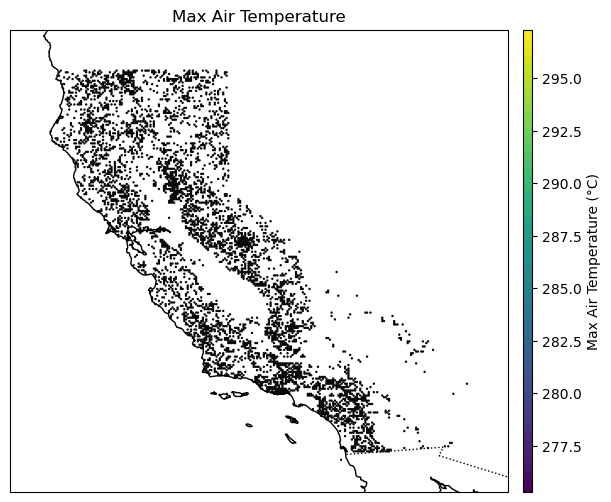

In [90]:
# Plot the map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([temp_dat['lon'].min() - 1, temp_dat['lon'].max() + 1, temp_dat['lat'].min() - 1, temp_dat['lat'].max() + 1], crs=ccrs.PlateCarree())

# Add coastlines and borders for context
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the max_air_temperature
sc = plt.scatter(temp_dat['lon'], temp_dat['lat'], c=temp_dat['max_air_temperature'], cmap='viridis', s=0.5, edgecolor='k', transform=ccrs.PlateCarree())

# Add a color bar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, aspect=50)
cbar.set_label('Max Air Temperature (°C)')

# Add a title
plt.title('Max Air Temperature')

# Show the plot
plt.show()

In [107]:
# remove rows in panda_df that have date, lon, lat in remove_dat1, print the shape of panda_df before and after
print(f"Shape of panda_df before: {panda_df.shape}")
panda_df = panda_df[~panda_df.set_index(['day', 'lon', 'lat']).index.isin(remove_dat1.set_index(['day', 'lon', 'lat']).index)]
print(f"Shape of panda_df after: {panda_df.shape}")

Shape of panda_df before: (40555200, 14)
Shape of panda_df after: (40554222, 14)


In [175]:
# check lon and lat combination is unique in vegetation_dat
vegetation_dat[['lon', 'lat']].duplicated().sum()

0

In [183]:
vegetation_dat.head()

,lon,lat,type,distance_to_first
269,-124.374975,40.452058,7.0,0.000000
270,-124.374975,40.410392,25.0,4.633122
496,-124.333309,40.577058,1.0,14.338719
497,-124.333309,40.535392,8.0,9.913501
498,-124.333309,40.493725,25.0,5.821319


In [195]:
first_row = vegetation_dat.iloc[1]

In [196]:
vegetation_dat['distance_to_first'] = vegetation_dat.apply(
    lambda row: geodesic((first_row['lat'], first_row['lon']), (row['lat'], row['lon'])).km, axis=1
)

In [197]:
# order vegetation_dat by distance_to_first
tt = vegetation_dat.sort_values(by='distance_to_first')
tt.head()

,lon,lat,type,distance_to_first
270,-124.374975,40.410392,25.0,0.000000
500,-124.333309,40.410392,25.0,3.536685
269,-124.374975,40.452058,7.0,4.626789
499,-124.333309,40.452058,10.0,5.823023
501,-124.333309,40.368725,25.0,5.824321


In [185]:
# order vegetation_dat by distance_to_first
tt = vegetation_dat.sort_values(by='distance_to_first')
tt.head()

,lon,lat,type,distance_to_first
269,-124.374975,40.452058,7.0,0.000000
499,-124.333309,40.452058,10.0,3.525570
270,-124.374975,40.410392,25.0,4.633122
498,-124.333309,40.493725,25.0,5.821319
500,-124.333309,40.410392,25.0,5.822643


In [192]:
from geopy.distance import geodesic

# Define the coordinates
coords_1 = (40.452058, -124.374975)
coords_2 = (40.41039, -124.374975)

# Calculate the distance
distance = geodesic(coords_1, coords_2).km

# Print the distance
print(f"Distance: {distance} km")

Distance: 4.626936837923472 km


In [ ]:
#import numpy as np
#from tqdm import tqdm

# Function to find the nearest longitude and latitude
def find_nearest(lon, lat, lon_array, lat_array):
    lon_grid, lat_grid = np.meshgrid(lon_array, lat_array)
    dist = np.sqrt((lon_grid - lon)**2 + (lat_grid - lat)**2)
    idx = np.argmin(dist)
    return np.unravel_index(idx, lon_grid.shape)

# Initialize lists to store the nearest indices
nearest_lons = []
nearest_lats = []

# Iterate over the centroids
for centroid in tqdm(gdf_wgs84['centroid']):
    lon = centroid.x
    lat = centroid.y
    lat_idx, lon_idx = find_nearest(lon, lat, merged_weather_dat.lon.values, merged_weather_dat.lat.values)
    nearest_lon = merged_weather_dat.lon.values[lon_idx]
    nearest_lat = merged_weather_dat.lat.values[lat_idx]
    nearest_lons.append(nearest_lon)
    nearest_lats.append(nearest_lat)

# Add the nearest indices to the GeoDataFrame
gdf_wgs84['nearest_lon'] = nearest_lons
gdf_wgs84['nearest_lat'] = nearest_lats

In [177]:
# extract lon and lat from vegetation_dat first row
lon = vegetation_dat.iloc[0]['lon']
lat = vegetation_dat.iloc[0]['lat']
lon, lat

(-124.37497533766633, 40.4520584276667)

In [178]:
# in panda_df, find the row that has lon and lat equal to the extracted lon and lat
panda_df[(panda_df['lon'] == lon)]

,day,lon,lat,dead_fuel_moisture_1000hr,dead_fuel_moisture_100hr,max_air_temperature,max_relative_humidity,min_air_temperature,min_relative_humidity,precipitation_amount,specific_humidity,surface_downwelling_shortwave_flux_in_air,wind_from_direction,wind_speed


In [180]:
# in panda_df, extract all lon that is between lon-0.05 and lon+0.05, and lat that is between lat-0.05 and lat+0.05
temp_dat = panda_df[(panda_df['lon'] > lon - 0.05) & (panda_df['lon'] < lon+0.05) & (panda_df['lat'] > lat-0.05) & (panda_df['lat'] < lat+0.05)]
# check the unique pairs of lon and lat
temp_dat[['lon', 'lat']].drop_duplicates()

,lon,lat
0,-124.391667,40.483333


In [99]:
# inner join panda_df and vegetation_dat by lon and lat, print the shape of panda_df before and after
print(f"Shape of panda_df before: {panda_df.shape}")
panda_df = panda_df.merge(vegetation_dat, on=['lon', 'lat'], how='inner')
print(f"Shape of panda_df after: {panda_df.shape}")

Shape of panda_df before: (40554222, 14)
Shape of panda_df after: (0, 15)


In [198]:
panda_df.columns

Index(['day', 'lon', 'lat', 'dead_fuel_moisture_1000hr',
       'dead_fuel_moisture_100hr', 'max_air_temperature',
       'max_relative_humidity', 'min_air_temperature', 'min_relative_humidity',
       'precipitation_amount', 'specific_humidity',
       'surface_downwelling_shortwave_flux_in_air', 'wind_from_direction',
       'wind_speed'],
      dtype='object')

In [200]:
lon_lat_pair = panda_df[['lon', 'lat']].drop_duplicates()

In [201]:
# Function to find the nearest type within 4 km
def find_nearest_type(row, vegetation_dat):
    distances = vegetation_dat.apply(lambda row2: geodesic((row['lat'], row['lon']), (row2['lat'], row2['lon'])).km, axis=1)
    min_distance = distances.min()
    if min_distance < 4:
        nearest_index = distances.idxmin()
        return vegetation_dat.iloc[nearest_index]['type'], min_distance
    else:
        return np.nan, np.nan

# Apply the function to each row in lon_lat_pair
lon_lat_pair[['type', 'distance']] = lon_lat_pair.apply(lambda row: pd.Series(find_nearest_type(row, vegetation_dat)), axis=1)

IndexError: single positional indexer is out-of-bounds

In [ ]:
# save data to parquet file
lon_lat_pair.to_parquet('../Clean_Data/lon_lat_pair_weather_match_veg.parquet')

In [ ]:
lon_lat_pair.shape

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


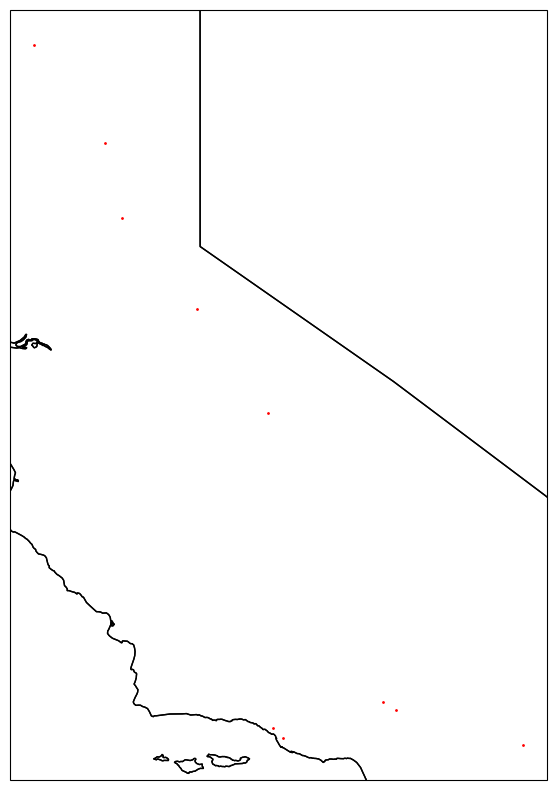

In [41]:
# ploy the centroids on a map
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.scatter(date_error_rows['centroid'].x, date_error_rows['centroid'].y, transform=ccrs.PlateCarree(), color='red', s=1)
plt.show()

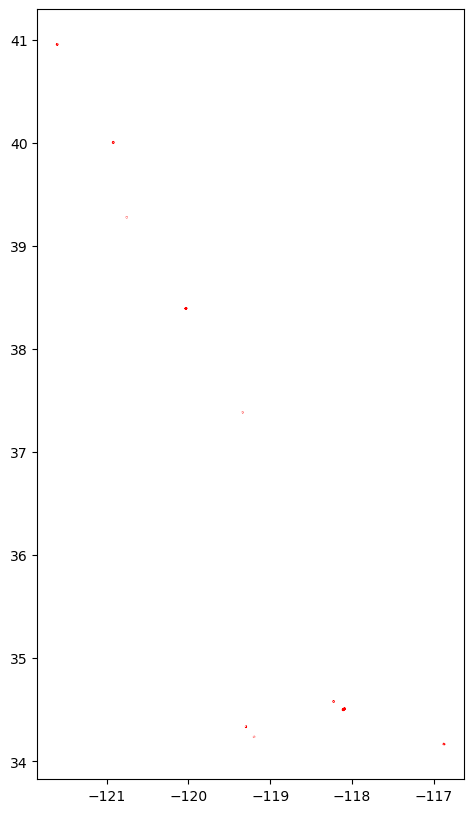

In [40]:
# plot the boundary of the date_error_rows using geoometry
fig, ax = plt.subplots(figsize=(10, 10))
date_error_rows.boundary.plot(ax=ax, color='red')
plt.show()

In [37]:
panda_df.head()

,day,lon,lat,dead_fuel_moisture_1000hr,dead_fuel_moisture_100hr,max_air_temperature,max_relative_humidity,min_air_temperature,min_relative_humidity,precipitation_amount,specific_humidity,surface_downwelling_shortwave_flux_in_air,wind_from_direction,wind_speed
0,2001-01-01,-124.391667,40.483333,24.900000,21.000000,287.5,100.0,277.0,56.700001,NaN,0.00602,103.599998,356.0,4.8
1,2001-01-01,-124.308333,40.233333,23.800001,19.700001,286.6,100.0,277.8,56.799999,NaN,0.00585,104.500000,344.0,4.4
2,2001-01-01,-124.266667,40.316667,24.700001,20.500000,286.6,100.0,277.1,51.900002,NaN,0.00573,108.700005,352.0,4.4
3,2001-01-01,-124.266667,40.191667,24.200001,20.400000,287.1,100.0,278.3,55.900002,NaN,0.00606,103.900002,344.0,4.1
4,2001-01-01,-124.225000,41.858333,26.500000,21.000000,286.3,100.0,277.5,59.000000,NaN,0.00579,82.300003,338.0,1.8
